<div align="center">

---
# NVIDIA Stock Forecasting
---
</div>

This Project mainly focuses on trying to predict the NVIDIA Stock's Market price using data from the yahoo Finance market history for this stock as well as with Long Short-Term Memory Models (LSTM's).

In [1]:
# dataset @ https://finance.yahoo.com/quote/NVDA/history/

In [2]:
# Importing Dependencies
import numpy as np
import pandas as pd

# Import matplotlib to help visualize the data
import matplotlib.pyplot as plt

# Import Datetime to properly format the Dates from the Dataset
from datetime import (datetime, timedelta)

In [3]:
# Loading the Dataset
df = pd.read_csv("./NVDA.csv")

In [4]:
# Getting the Number of Rows and Columns of the Dataset
n_rows, n_cols = df.shape
print(f"The dataset contains {n_rows} rows and {n_cols} columns")

The dataset contains 6416 rows and 7 columns


In [5]:
# Getting Initial / Oldest 5 Records
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-22,0.043750,0.048828,0.038802,0.041016,0.037621,2714688000
1,1999-01-25,0.044271,0.045833,0.041016,0.045313,0.041562,510480000
2,1999-01-26,0.045833,0.046745,0.041146,0.041797,0.038337,343200000
3,1999-01-27,0.041927,0.042969,0.039583,0.041667,0.038218,244368000
4,1999-01-28,0.041667,0.041927,0.041276,0.041536,0.038098,227520000


In [6]:
# Getting Final / Most Recent 5 Records
df.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume
6411,2024-07-17,121.349998,121.849998,116.720001,117.989998,117.989998,390086200
6412,2024-07-18,121.849998,122.400002,116.559998,121.089996,121.089996,320979500
6413,2024-07-19,120.349998,121.599998,117.370003,117.930000,117.930000,217223800
6414,2024-07-22,120.349998,124.070000,119.860001,123.540001,123.540001,258068900
6415,2024-07-23,122.779999,124.690002,122.099998,122.589996,122.589996,167896533


In [7]:
# Selecting Important Columns
df = df[['Date', 'Close']]
df.head(3)

,Date,Close
0,1999-01-22,0.041016
1,1999-01-25,0.045313
2,1999-01-26,0.041797


In [8]:
# Defining a Function to convert the string dates of the dataset into datetime object instances
def str_to_datetime(string_date:str) -> datetime:
    """
    := param: string_date -> String that we want to convert into a datetime type object [Eg: '2003-10-10']
    """
    # Fetching the year, month and day from the string and convert them into int
    year, month, day = list(map(int, string_date.split('-')))

    # Return a instance of datetime with the respective extracted attributes from the given string
    return datetime(year=year, month=month, day=day)

In [9]:
# Getting a date string from the dataset [In this case it is the first one]
first_date_datset = df['Date'][0]

# Testing the previous function on the extracted date
str_to_datetime(first_date_datset)

datetime.datetime(1999, 1, 22, 0, 0)

In [10]:
# Now, let's update the dataframe in order for the dates to be formated accordingly with this most recent approach
df['Date'] = df['Date'].map(lambda date_string : str_to_datetime(date_string))

# Inspect the result
df['Date']

0      1999-01-22
1      1999-01-25
2      1999-01-26
3      1999-01-27
4      1999-01-28
          ...    
6411   2024-07-17
6412   2024-07-18
6413   2024-07-19
6414   2024-07-22
6415   2024-07-23
Name: Date, Length: 6416, dtype: datetime64[ns]

In [11]:
# Set the Date column as the index column
df.set_index('Date', inplace=True)

# Inspect the dataframe
df.head(3)

,Close
Date,
1999-01-22,0.041016
1999-01-25,0.045313
1999-01-26,0.041797


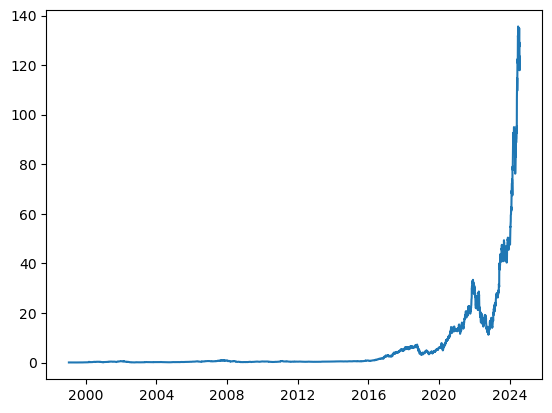

In [12]:
# Plotting the Closing Values of the Stock throughout the years
plt.plot(df.index, df['Close'])

In [13]:
# Since we are going to use a LSTM model, we need to convert the provlem into a supervised learning problem

# This function creates a Dataframe with multiple target columns which are going to
# be used within the long short-term memory model
def df_to_windowed_df(dataframe:pd.DataFrame, first_date_str:str, last_date_str:str, n:int=3) -> pd.DataFrame:
    # Converting the string dates
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    # Defining a current date to be iterated over
    target_date = first_date
    dates = X = Y = []

    # Creating a flag to determine the last time...
    last_time = False

    while True:
        # Selecting a Subset of the datafrane 
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if df_subset.shape[0] != n+1:
            print(f'[ERROR]: Window of Size {n} is too large for date {target_date}')
            return

        # Getting the closing values for the current subset (Current time interval [initial_date - current_date(updates at each new iteration on the while cycle)])
        values = df_subset['Close'].to_numpy()
        
        # Spliting the values into 
        x, y = values[:-1], values[-1]
        
        # Update the initial lists with the new values
        dates.append(target_date)
        X.append(x)
        Y.append(y)
        
        # Getting the date for the next week -> We consider consecutive entries the ones that are 1 week apart
        next_week = dataframe.loc[target_date:target_date + timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        
        # Extracting the year, month and day
        year, month, day = list(map(int, next_date_str.split('-')))
        
        # Create a new instance of datetime for the next date (date to consider for the next iteration)
        next_date = datetime(year=year, month=month, day=day)

        # Reached the Final / Target date
        if last_time:
            break

        # Updating the Target Date
        target_date = next_date

        # Current Date == Last Date to consider
        if target_date == last_date:
            last_time = True

        # Initializing the Target Dataframe with all the valid dates to which we want to train the model with
        target_df = pd.DataFrame({})
        target_df['Target_Date'] = dates
        
        print(X)
        
        # Converting the X list into a numpy array
        X = np.array(X, dtype='object')
        
        # For each entry in the dataset, we look for the i - <n> entry and add it as a new column to the dataframe
        for i in range(0, n):
            # X[:, i]
            target_df[f'Target-{n-1}'] = X[:, i]

    target_df['Target'] = Y

    # Return the new dataframe
    return target_df

In [14]:
# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

[datetime.datetime(2021, 3, 25, 0, 0), array([13.18625, 13.07075, 12.643  ]), 12.53525]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed